# PROJECT NAME

---
## Import Relevant Libraries
---

In [1]:
import os.path
import pandas as pd
import tensorflow as tf
from fileMaster import *
import plotly.express as px
import plotly.graph_objects as go
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn import tree
from matplotlib.colors import ListedColormap, to_rgb
import numpy as np

-----
## Preliminary Cleaning | Clean ill-formated Data
-----

In [2]:
with open(raw_data_txt, 'r', encoding='utf-8') as f:
    raw_lines = f.readlines()

df = pd.DataFrame(columns=['Type', 'Msg'])

count = 0

for line in raw_lines:
    # Encode Sensitive Info
    line = line.replace("&lt;#&gt;", "[NUM]").replace(" [NUM] ", "[NUM]")
    line = line.replace("&lt;DECIMAL&gt;", "[DEC]").replace(" [DEC] ", "[DEC]")
    line = line.replace("&lt;URL&gt;", "[URL]").replace(" [URL] ", "[URL]")
    line = line.replace("&lt;TIME&gt;", "[TIME]").replace(" [URL] ", "[URL]")
    line = line.replace("&lt;EMAIL&gt;", "[EMAIL]").replace(" [EMAIL] ", "[EMAIL]")

    # Replace Known Strings
    line = line.replace("&lt;3", "[HEART]").replace(" [HEART] ", "[HEART]")
    line = line.replace("&lt;", "<")
    line = line.replace("&gt;", ">")
    line = line.replace("&amp;", "&")

    # Replace Special Characters
    line = line.replace("\x92", "'")
    line = line.replace("Bill said u or ur rents", 'Bill said u or ur parents')
    line = line.replace("MORROW", "TOMORROW")
    line = line.replace(" ", "")
    line = line.replace("ü", "u")
    line = line.replace("Ü", "U")
    line = line.replace("", "")
    line = line.replace("", " ")

    # Replace Unknown Characters
    line = line.replace("鈥┾??〨ud", "[UNK]")

    _lst = line.split('\t')
    _type = _lst[0]
    _msg = _lst[1].strip()

    d = {'Type': _type, 'Msg': _msg}
    df2 = pd.DataFrame(d, [count])

    df = pd.concat([df, df2], axis=0)

    count += 1

df.to_csv(data_folder / 'cleaned.csv', sep=',', encoding='utf-8', index=False)

In [3]:
df.head()

Type                                                Msg
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...

---
## Verify Tensorflow GPU is Identified
---

In [4]:
if tf.test.gpu_device_name():

    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

else:

   print("Please install GPU version of TF")


Please install GPU version of TF


---
## Exploratory Data Analysis
---

### <blockquote>Basic Statistics

In [5]:
df.groupby("Type").describe()

Msg                                                               
     count unique                                                top freq
Type                                                                     
ham   4827   4518                             Sorry, I'll call later   30
spam   747    642  Please call our customer service representativ...    4

In [6]:
eda_type_count_df = pd.DataFrame({'Count': [df['Type'].value_counts()['ham'], df['Type'].value_counts()['spam']], 'Type': ['Ham', 'Spam']}, ['Ham', 'Spam'])
eda_type_count_fig = px.bar(eda_type_count_df, x='Type', y='Count', orientation='v', color_discrete_sequence=["#A0e7A0", "#FF8986"], color='Type', title='Count of Message Types', text_auto='', template='plotly')
eda_type_count_fig.show()

The number of datapoints is skewed heavily in favor of Ham messages. This is unsurprising, given that on a daily basis most people receive more ham than spam. However, this may lead to potential implicit biasness in our models. Hence, we will be using our models on a balanced dataset and the original to determine the effects of such a skew.

### <blockquote>Tokenization

In [7]:
def tokenization(msg, punc_remove=False):
    punct_lst = ['...', '..', ",", '.', ';', '<', '>', '/', '"', '&', '!', '@', '#', '?', ]

    strng = msg

    for p in punct_lst:

        if ('..'  in strng or '...' in strng) and p == '.':
            pass
        else:
            temp_lst = strng.split(p)
            temp_lst = [x.rstrip() for x in temp_lst]
            temp_lst = [x.lstrip() for x in temp_lst]

            if punc_remove:
                strng = f' '.join(temp_lst)
            else:
                strng = f' {p} '.join(temp_lst)

    word_lst = strng.split(' ')

    if not punc_remove:
        count = 0

        punct_lst.remove('..')
        punct_lst.remove('...')

        for w in word_lst:
            try:
                for p in punct_lst:
                    if  w == 2*p and word_lst[count+1] == p:
                        word_lst[count] = 3*p
                        word_lst.pop(count + 1)
            except IndexError:  
                '''
                Index error occurs when we are at the last element of list and 
                try to access the next element, this means that the ".." is at the 
                last element so we do not to do anything abt it
                
                '''
                pass

            count += 1

    return word_lst

Above is our own function to tokenize the words in the messages.

In [8]:
def split_sentence(msg):
    punct_lst = ['...', '..', '.', '?', '!', ';']

    strng = msg

    for p in punct_lst:

        if ('..'  in strng or '...' in strng) and p == '.':
            pass
        else:
            temp_lst = strng.split(p)
            temp_lst = [x.rstrip() for x in temp_lst]
            temp_lst = [x.lstrip() for x in temp_lst]
            strng = f'|'.join(temp_lst)

    sentence_lst = strng.split('|')

    sym_lst = ['...', '..', ",", '.', ';', '<', '>', '/', '"', '&', '!', '@', '#', '?', ' ', '']
    for s in sentence_lst:
        if s in sym_lst:
            sentence_lst.remove(s)

    return sentence_lst

Above is our own function to tokenize the sentences in the messages.

In [9]:
# Tokenize Characters
df['CharCount'] = df['Msg'].apply(lambda x: len(x))

# Tokenize Words
df['ListWords'] = df['Msg'].apply(lambda x: tokenization(x))
df['NumWords'] = df['Msg'].apply(lambda x: len(tokenization(x, punc_remove=True)))

# Tokenize Sentences
df['ListSentence'] = df['Msg'].apply(lambda x: split_sentence(x))
df['NumSentences'] = df['Msg'].apply(lambda x: len(split_sentence(x)))

In [10]:
df.head()

Type                                                Msg  CharCount  \
0   ham  Go until jurong point, crazy.. Available only ...        111   
1   ham                      Ok lar... Joking wif u oni...         29   
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...        155   
3   ham  U dun say so early hor... U c already then say...         49   
4   ham  Nah I don't think he goes to usf, he lives aro...         61   

                                           ListWords  NumWords  \
0  [Go, until, jurong, point, ,, crazy, .., Avail...        20   
1           [Ok, lar, ..., Joking, wif, u, oni, ...]         6   
2  [Free, entry, in, 2, a, wkly, comp, to, win, F...        29   
3  [U, dun, say, so, early, hor, ..., U, c, alrea...        11   
4  [Nah, I, don't, think, he, goes, to, usf, ,, h...        13   

                                        ListSentence  NumSentences  
0  [Go until jurong point, crazy, Available only ...             3  
1                         [Ok lar, Joking wif u oni]             2  
2  [Free entry in 2 a wkly comp to win FA Cup fin...             2  
3     [U dun say so early hor, U c already then say]             2  
4  [Nah I don't think he goes to usf, he lives ar...             1

First 5 messages and their character, words and sentences tokenized and counted.

In [11]:
df.tail()

Type                                                Msg  CharCount  \
5569  spam  This is the 2nd time we have tried 2 contact u...        160   
5570   ham               Will u b going to esplanade fr home?         36   
5571   ham  Pity, * was in mood for that. So...any other s...         57   
5572   ham  The guy did some bitching but I acted like i'd...        125   
5573   ham                         Rofl. Its true to its name         26   

                                              ListWords  NumWords  \
5569  [This, is, the, 2nd, time, we, have, tried, 2,...        30   
5570  [Will, u, b, going, to, esplanade, fr, home, ?, ]         9   
5571  [Pity, ,, *, was, in, mood, for, that., So, .....        12   
5572  [The, guy, did, some, bitching, but, I, acted,...        26   
5573                [Rofl, ., Its, true, to, its, name]         6   

                                           ListSentence  NumSentences  
5569  [This is the 2nd time we have tried 2 contact ...             5  
5570              [Will u b going to esplanade fr home]             1  
5571  [Pity, * was in mood for that, So, any other s...             3  
5572  [The guy did some bitching but I acted like i'...             1  
5573                       [Rofl, Its true to its name]             2

Last 5 messages and their character, words and sentences tokenized and counted.

### <blockquote> Histograms of *CharCount*, *NumWords*, *NumSentence*

In [12]:
eda_charc_hist = px.histogram(df[['CharCount', 'Type']], 
                              x='CharCount', 
                              color='Type', 
                              template='plotly', 
                              title='Histogram on Number of Characters', 
                              color_discrete_sequence=["#A0e7A0", "#FF8986"])
eda_charc_hist.update_layout(barmode='overlay')

It is interesting note that most **spam** messages have a **higher** character count (i.e. the mode of spam messages lies between 155-159 characters) than ham messages (i.e. mode of ham messages lies between 25-29 characters). Furthermore, the distribution of ham messages is **positively** skewed, whereas that of spam messages is **negatively** skewed.

In [13]:
eda_charc_hist = px.histogram(df[['NumWords', 'Type']], 
                              x='NumWords', 
                              color='Type', 
                              template='plotly', 
                              title='Histogram on Number of Words', 
                              color_discrete_sequence=["#A0e7A0", "#FF8986"])
eda_charc_hist.update_layout(barmode='overlay')

It is interesting note that most **spam** messages have a **higher** word count (i.e. the mode of spam messages lies at 28 words) than ham messages (i.e. mode of ham messages lies at 6 words). Furthermore, the two distributions of CharCount and NumWords look fairly similar in shape. Hence, the distribution of ham messages is still **positively** skewed, whereas that of spam messages is still **negatively** skewed.

In [14]:
eda_charc_hist = px.histogram(df[['NumSentences', 'Type']], 
                              x='NumSentences', 
                              color='Type', 
                              template='plotly', 
                              title='Histogram on Number of Sentences', 
                              color_discrete_sequence=["#A0e7A0", "#FF8986"])
eda_charc_hist.update_layout(barmode='overlay')

**Visually**, it is interesting to note that the **distribution** of **spam** messages **seem to follow a Normal Distribution**, with the mode of **spam** messages being at 3, which is significantly higher than that of **ham** messages (whose mode lies at 1 sentence). It is also unsurprising that the distribution of **ham** messages have a **positive** skew, considering that most people will limit their text to around a sentence in this day and age. Hence, our group postulates that, **ceteris paribus**, the **likelihood** of a message being a **spam** message is high should there be 3-4 sentences.

### <blockquote> Box-Plots of *CharCount*, *NumWords*, *NumSentence*

In [15]:
def genBoxPlot(var):
    box_fig = go.Figure()
    box_fig.layout.title = f'Box-Plots of Spam and Ham for {var}'
    ham_df = df[df['Type']=='ham']
    temp_df = df

    temp_df['Ham'] = ham_df[var]
    spam_df = df[df['Type']=='spam']
    temp_df['Spam'] = spam_df[var]


    for col in temp_df[['Ham', 'Spam']]:
        box_fig.add_trace(
            go.Box(x=temp_df[col].values,
                   name=temp_df[col].name,
                   fillcolor=["#CEF3CE", "#FFEBEB"][['Ham', 'Spam'].index(col)],
                   line={'color': ["#6BDB6B", "#FF8986"][['Ham', 'Spam'].index(col)]}
                   )
        )
    box_fig.update_traces(orientation='h')
    box_fig.show()
    return temp_df

Above is our own function to generate the box-plots for the various types of counts and their type of message.

In [16]:
# Call function to generate Box-Plots for CharCount, NumWords and NumSentences

genBoxPlot('CharCount')
genBoxPlot('NumWords')
genBoxPlot('NumSentences')

Type                                                Msg  CharCount  \
0      ham  Go until jurong point, crazy.. Available only ...        111   
1      ham                      Ok lar... Joking wif u oni...         29   
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...        155   
3      ham  U dun say so early hor... U c already then say...         49   
4      ham  Nah I don't think he goes to usf, he lives aro...         61   
...    ...                                                ...        ...   
5569  spam  This is the 2nd time we have tried 2 contact u...        160   
5570   ham               Will u b going to esplanade fr home?         36   
5571   ham  Pity, * was in mood for that. So...any other s...         57   
5572   ham  The guy did some bitching but I acted like i'd...        125   
5573   ham                         Rofl. Its true to its name         26   

                                              ListWords  NumWords  \
0     [Go, until, jurong, point, ,, crazy, .., Avail...        20   
1              [Ok, lar, ..., Joking, wif, u, oni, ...]         6   
2     [Free, entry, in, 2, a, wkly, comp, to, win, F...        29   
3     [U, dun, say, so, early, hor, ..., U, c, alrea...        11   
4     [Nah, I, don't, think, he, goes, to, usf, ,, h...        13   
...                                                 ...       ...   
5569  [This, is, the, 2nd, time, we, have, tried, 2,...        30   
5570  [Will, u, b, going, to, esplanade, fr, home, ?, ]         9   
5571  [Pity, ,, *, was, in, mood, for, that., So, .....        12   
5572  [The, guy, did, some, bitching, but, I, acted,...        26   
5573                [Rofl, ., Its, true, to, its, name]         6   

                                           ListSentence  NumSentences  Ham  \
0     [Go until jurong point, crazy, Available only ...             3  3.0   
1                            [Ok lar, Joking wif u oni]             2  2.0   
2     [Free entry in 2 a wkly comp to win FA Cup fin...             2  NaN   
3        [U dun say so early hor, U c already then say]             2  2.0   
4     [Nah I don't think he goes to usf, he lives ar...             1  1.0   
...                                                 ...           ...  ...   
5569  [This is the 2nd time we have tried 2 contact ...             5  NaN   
5570              [Will u b going to esplanade fr home]             1  1.0   
5571  [Pity, * was in mood for that, So, any other s...             3  3.0   
5572  [The guy did some bitching but I acted like i'...             1  1.0   
5573                       [Rofl, Its true to its name]             2  2.0   

      Spam  
0      NaN  
1      NaN  
2      2.0  
3      NaN  
4      NaN  
...    ...  
5569   5.0  
5570   NaN  
5571   NaN  
5572   NaN  
5573   NaN  

[5574 rows x 9 columns]

Comparing the box-plots of **ham** and **spam** messages for CharCount, NumWords and NumSentences, our group notices that for each category, the **ham** and **spam** box-plots are **evidently different**. Hence, it is clear that **there exists some form of relation between CharCount, NumWords or NumSentences and the type of message (spam or ham).** Furthermore, the disparity between the box-plots vary the greatest for **CharCount**, indicating that **CharCount might be the best predictor for the type of message.** Whereas the disparity between the box-plots vary the least for **NumSentences**, indicating that **NumSentences might be the least effective predictor for the type of message.** 

### <blockquote> Scatter Plots of *CharCount*, *NumWords*, *NumSentence*

In [17]:
scatter_plot = px.scatter_matrix(df,
                                 dimensions=["CharCount", "NumWords", "NumSentences"],
                                 color = "Type",
                                 template = 'plotly',
                                 color_discrete_map = {'ham': '#6BDB6B', 'spam': '#FF8986'},
                                 title = "Pair Plot of all 3 Features",
                                 )
scatter_plot.update_traces(diagonal_visible=False)
scatter_plot.show()

Analyzing the Scatter Plots for each type of count, it is immediately noticeable that there exists **a very strong linear relationship between CharCount and NumWords.** This makes sense as logically, **having more characters would generally mean more words, and vice versa.** Furthermore, this explains the **similarity in the distributions of the CharCount and NumWords histograms.** Hence, it is expected that **the correlation coefficient of CharCount and NumWords would be more than 0.8.**

However, the linear relation between NumSentences and CharCount or NumWords **does not display as strong of a linear relation between CharCount and NumWords.** This is evident from the Scatter Plots as there is **less of a clear line.** However, a **low to moderate linear relation can still be deduced.** This make sense as **having more characters and words might contribute to more sentences, but a sentence is ultimately defined by the use of certain punctuation marks, such as '.', '!' and '?'.** Hence, **the correlation coefficients of NumSentences and CharCount or NumWords would be expected to be below 0.8 but above 0.3.**

### <blockquote> Correlation Matrix Between *CharCount*, *NumWords*, *NumSentence*

In [18]:
def genCorrMatrix(type_msg):
    corr_df = df[df['Type']==type_msg]
    corr_df = corr_df[['CharCount', 'NumWords', 'NumSentences']]
    fig = px.imshow(corr_df.corr(),
                    text_auto=True,
                    color_continuous_scale = 'reds',
                    template = 'plotly_white',
                    title = f"Correlation Matrix for {type_msg} messages")
    fig.show()

In [19]:
genCorrMatrix('ham')
genCorrMatrix('spam')

With reference to the above **correlation matrices**:

**Ham Messages**

*r* (ham correlation coefficient of CharCount and NumWords) = 0.984484

*r* (ham correlation coefficient of NumSentences with CharCount) = 0.7148112

*r* (ham correlation coefficient of NumSentences with NumWords) = 0.7031104

**Spam Messages**

*r* (spam correlation coefficient of CharCount and NumWords) = 0.8891148

*r* (spam correlation coefficient of NumSentences with CharCount) = 0.3351989

*r* (spam correlation coefficient of NumSentences with NumWords) = 0.32212


Therefore, our earlier deductions from the **scatter plots** were accurate as a **high positive correlation produces 0.8 ≤ *r* < 1** and a **low to moderate positive correlation produces 0.3 ≤ *r* ≤ 0.8**.

Note: ***r* refers to the Pearson product-moment correlation coefficient.** It is a measure of the strength of the linear relationship between two variables. Pearson's *r* falls in the range -1 ≤ *r* ≤ 1. A perfect positive correlation produces *r* = 1 and a perfect negative correlation produces *r* = -1. No correlation between two variables produces *r* = 0.

### <blockquote>Binary Classification Tree: Predict *ham* or *spam* based on *CharCount, NumWords and NumSentences*

In [20]:
# Train-test Split
predictors = ['CharCount', 'NumWords', 'NumSentences']

pushThrough = True
default = False

if (not os.path.isfile(x_train_csv)) or default or not pushThrough:
    x = df[predictors]
    y = pd.DataFrame(df['Type'].astype('category'))
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25)

    # Save CSV
    if not os.path.isdir(train_test_folder):
        os.makedirs(train_test_folder)
    x_train.to_csv(x_train_csv, index=False)
    y_train.to_csv(y_train_csv, index=False)
    x_test.to_csv(x_test_csv, index=False)
    y_test.to_csv(y_test_csv, index=False)
else:
    # Load CSV
    x_train = pd.read_csv(x_train_csv)
    y_train = pd.read_csv(y_train_csv)
    x_test = pd.read_csv(x_test_csv)
    y_test = pd.read_csv(y_test_csv)

Split the dataset in Train and Test sets, uniformly at random.   
Train Set with 75% of data and Test Set with 25% of data.
Randomized set is saved for coherent analysis.

In [21]:
def genDecTree(depth, _x_train, _x_test, _y_train, _y_test):
    decTree = DecisionTreeClassifier(max_depth = depth)  # create the decision tree object
    decTree.fit(_x_train, _y_train)                    # train the decision tree model

    # Plot Tree
    if depth == 2:
        width = 25
        font_size = 25
    elif depth == 4:
        width = 80
        font_size = 30
    elif depth == 6:
        width = 240
        font_size = 40
    elif depth == 10:
        width = 240
    height = width / 2

    fontsize = depth*12.5

    colors = ['lightgreen', 'salmon']

    if depth < 6:
        plt.figure(figsize=(width,height))
        t = tree.plot_tree(decTree, filled=True, rounded=True, feature_names=_x_train.columns,
                           class_names=["Ham", "Spam"], fontsize=font_size)

        for a, impurity, value in zip(t, decTree.tree_.impurity, decTree.tree_.value):
            # let the max value decide the color; whiten the color depending on impurity (gini)
            r, g, b = to_rgb(colors[np.argmax(value)])
            _c = impurity * 2 # for N colors: f = impurity * N/(N-1) if N>1 else 0
            a.get_bbox_patch().set_facecolor((_c + (1-_c)*r, _c + (1-_c)*g, _c + (1-_c)*b))
            a.get_bbox_patch().set_edgecolor('black')

        plt.savefig(f'depth_{depth}_decTree.png')

    # Predict Response corresponding to Predictors
    y_train_pred = decTree.predict(_x_train)
    y_test_pred = decTree.predict(_x_test)

    # Check the Goodness of Fit (on Train Data)
    print("Goodness of Fit of Model \tTrain Dataset")
    print("Classification Accuracy \t:", decTree.score(_x_train, _y_train))
    print()

    # Check the Goodness of Fit (on Test Data)
    print("Goodness of Fit of Model \tTest Dataset")
    print("Classification Accuracy \t:", decTree.score(_x_test, _y_test))


    # Plot the Confusion Matrix for Train and Test
    train_fig = px.imshow(confusion_matrix(y_train, y_train_pred), text_auto=True, color_continuous_scale = 'reds',
                          template = 'plotly_white', title = f"Confusion Matrix for Train set, depth {depth}")
    test_fig = px.imshow(confusion_matrix(y_test, y_test_pred), text_auto=True, color_continuous_scale = 'reds',
                         template = 'plotly_white', title = f"Confusion Matrix for Test set, depth {depth}")
    
    # Calculate the various positive and negative rates
    
    cmTrain = confusion_matrix(y_train, y_train_pred)
    tpTrain = cmTrain[1][1] # True Positives 
    fpTrain = cmTrain[0][1] # False Positives 
    tnTrain = cmTrain[0][0] # True Negatives 
    fnTrain = cmTrain[1][0] # False Negatives 
    
    cmTest = confusion_matrix(y_test, y_test_pred)
    tpTest = cmTest[1][1] # True Positives 
    fpTest = cmTest[0][1] # False Positives 
    tnTest = cmTest[0][0] # True Negatives
    fnTest = cmTest[1][0] # False Negatives 

    print()
    print("TPR Train :\t", (tpTrain/(tpTrain + fnTrain)))
    print("TNR Test :\t", (tnTrain/(tnTrain + fpTrain)))
    print("FPR Train :\t", (fpTrain/(fpTrain + tnTrain)))
    print("FNR Test :\t", (fnTrain/(fnTrain + tpTrain)))
    print()

    print("TPR Test :\t", (tpTest/(tpTest + fnTest)))
    print("TNR Test :\t", (tnTest/(tnTest + fpTest)))
    print("FPR Test :\t", (fpTest/(fpTest + tnTest)))
    print("FNR Test :\t", (fnTest/(fnTest + tpTest)))
    
    # Display Classification Tree and Confusion Matrix  
    train_fig.show()
    test_fig.show()

Above is our own function to generate the binary classification tree and confusion matrix to predict the type of message using CharCount, NumWords and NumSentences as predictors.

| Confusion Matrix  |       |        |        |      
| :---              | :---: | :----: | :----: |         
| Actual Negative   |  (0)  |   TN   |   FP   |             
| Actual Positive   |  (1)  |   FN   |   TP   |       
|                   |       |   (0)   |   (1)   |       
|                   |       | Predicted Negative    |   Predicted Postitive  |     


* `TPR = TP / (TP + FN)` : True Positive Rate = True Positives / All Positives    
* `TNR = TN / (TN + FP)` : True Negative Rate = True Negatives / All Negatives    

* `FPR = FP / (TN + FP)` : False Positive Rate = False Positives / All Negatives 
* `FNR = FN / (TP + FN)` : False Negative Rate = False Negatives / All Positives 


Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.8988038277511962

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.8895265423242468

TPR Train :	 0.6954954954954955
TNR Test :	 0.9299310344827586
FPR Train :	 0.07006896551724139
FNR Test :	 0.3045045045045045

TPR Test :	 0.71875
TNR Test :	 0.9168053244592346
FPR Test :	 0.08319467554076539
FNR Test :	 0.28125


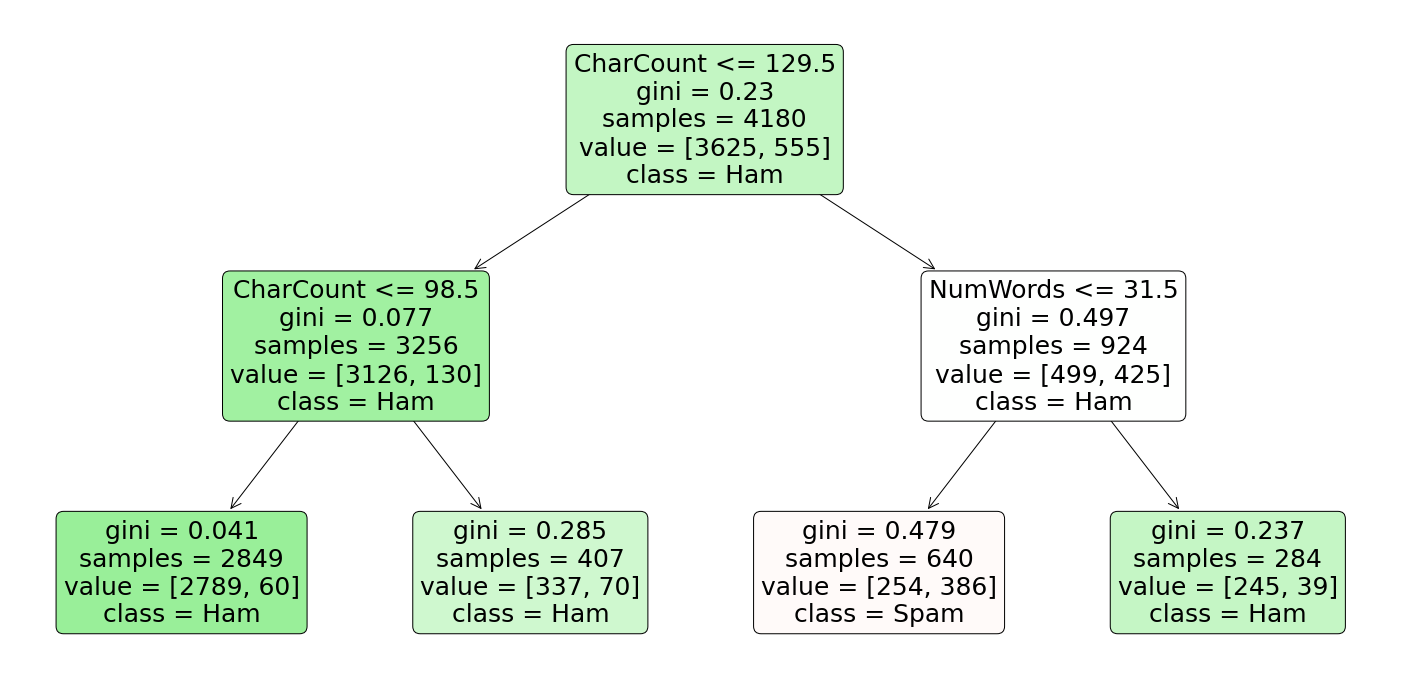

In [22]:
# Depth 2
genDecTree(2, x_train, x_test, y_train, y_test)

Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.9055023923444976

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.9067431850789096

TPR Train :	 0.5531531531531532
TNR Test :	 0.9594482758620689
FPR Train :	 0.04055172413793103
FNR Test :	 0.44684684684684683

TPR Test :	 0.5989583333333334
TNR Test :	 0.9559068219633944
FPR Test :	 0.04409317803660566
FNR Test :	 0.4010416666666667


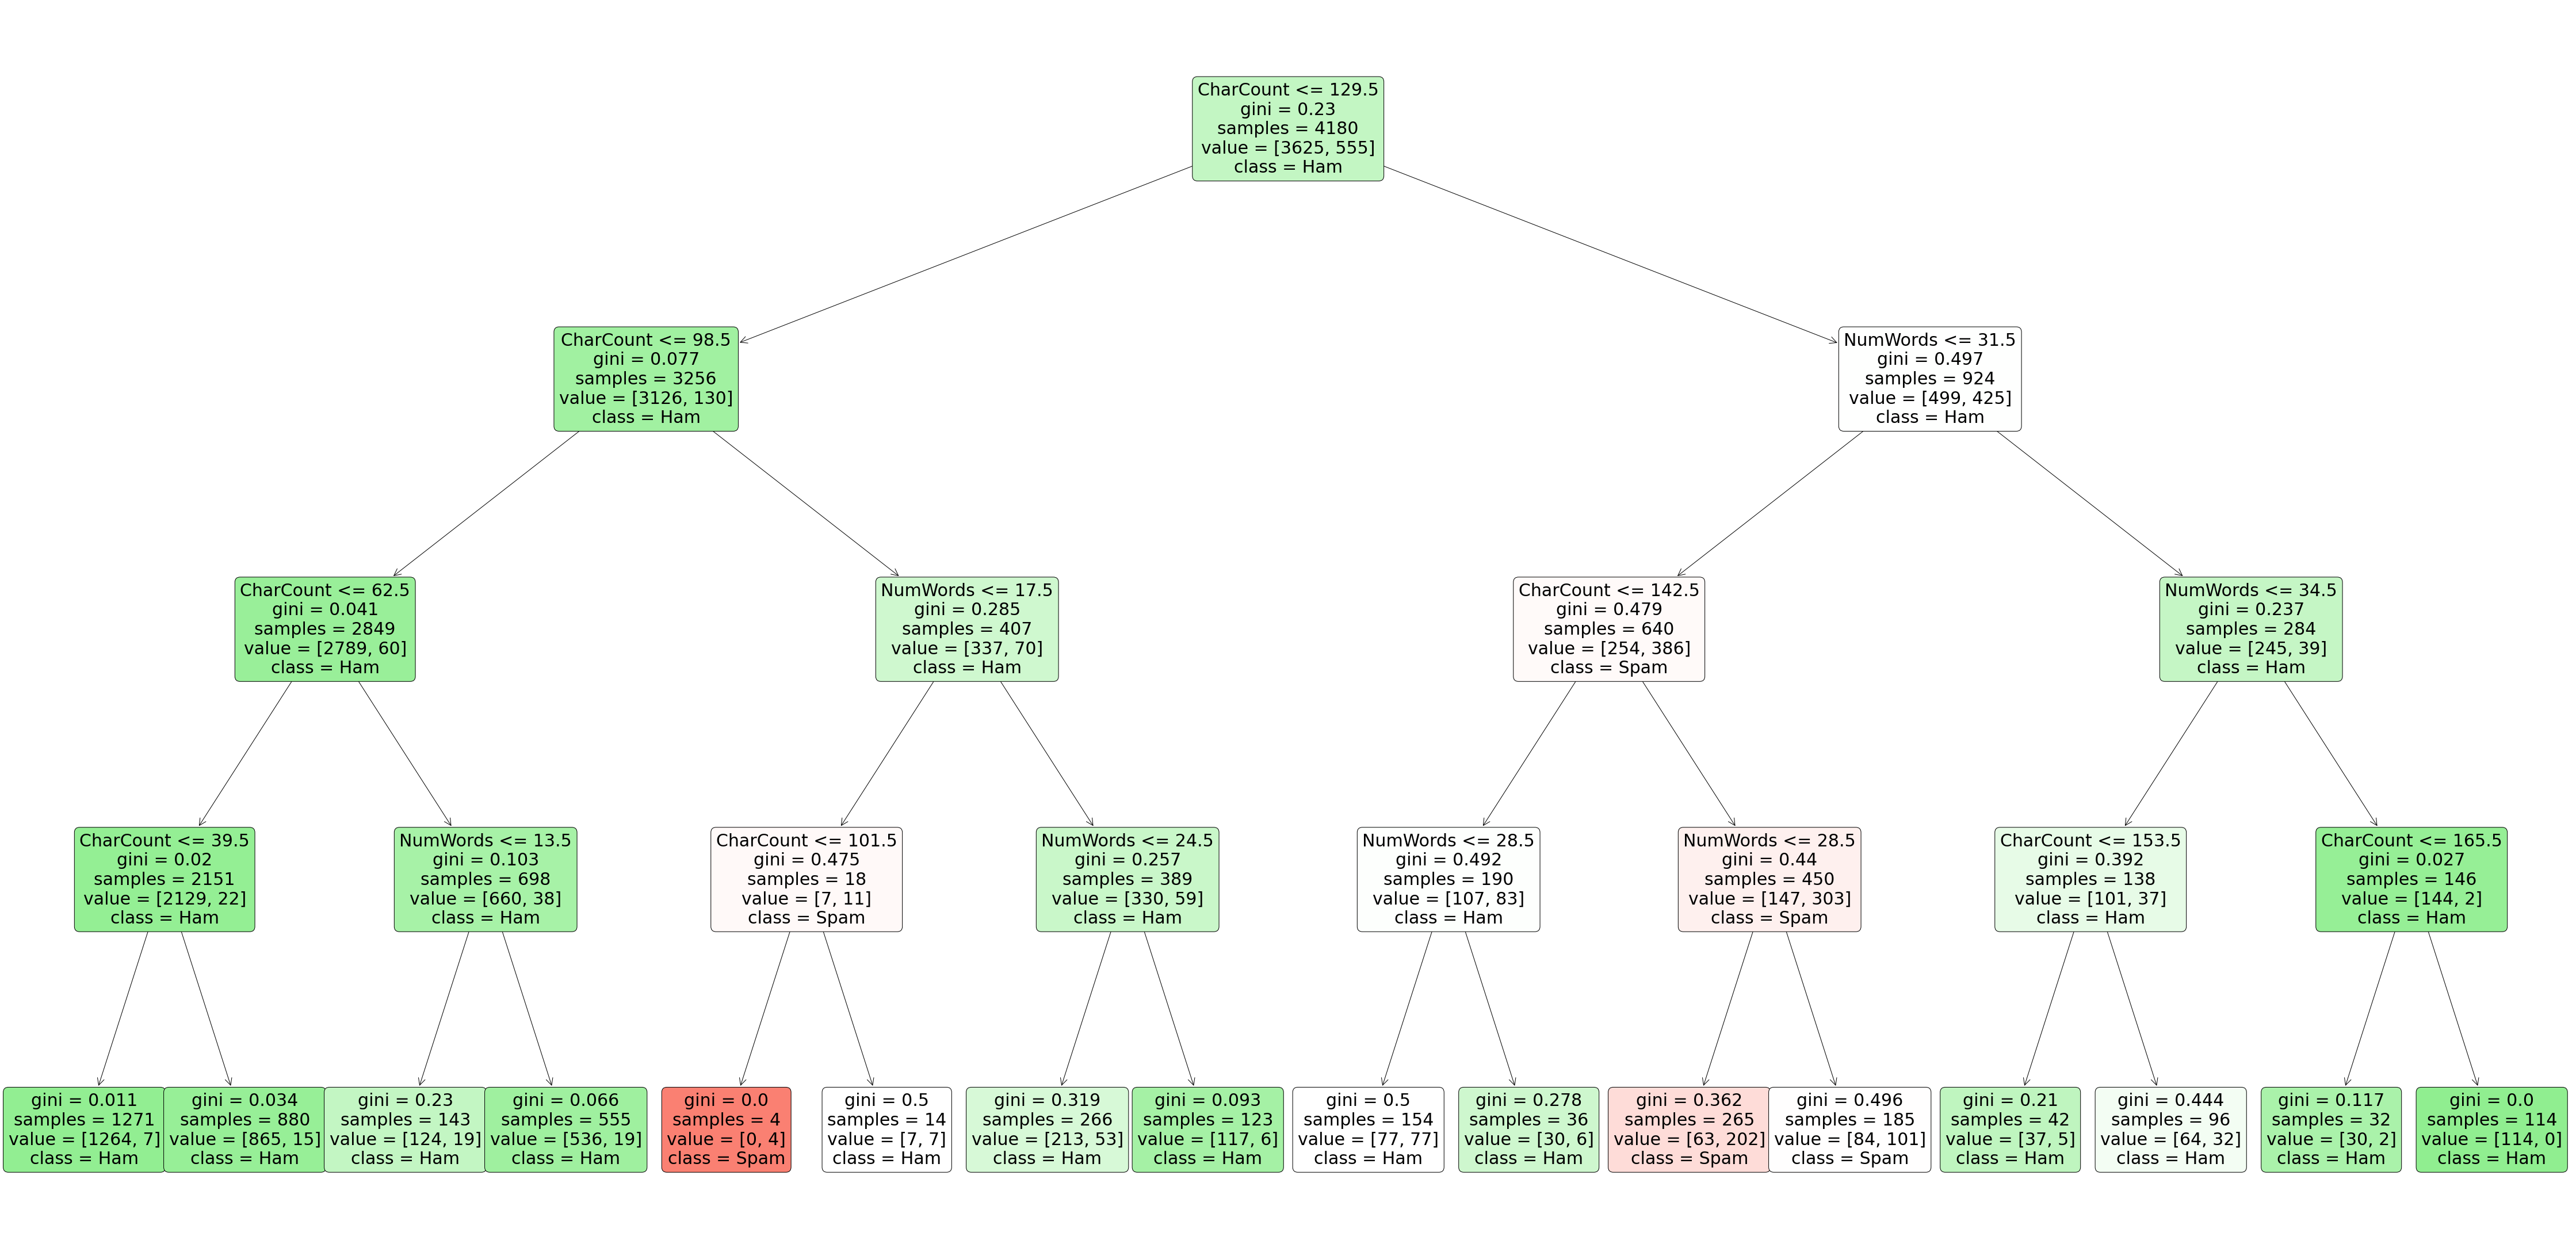

In [23]:
# Depth 4
genDecTree(4, x_train, x_test, y_train, y_test)

In [24]:
# Depth 6
genDecTree(6, x_train, x_test, y_train, y_test)

Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.919377990430622

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.9031563845050216

TPR Train :	 0.5423423423423424
TNR Test :	 0.977103448275862
FPR Train :	 0.02289655172413793
FNR Test :	 0.45765765765765765

TPR Test :	 0.53125
TNR Test :	 0.9625623960066556
FPR Test :	 0.03743760399334443
FNR Test :	 0.46875


In [25]:
# Depth 10
genDecTree(10, x_train, x_test, y_train, y_test)

Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.9454545454545454

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.8938307030129125

TPR Train :	 0.7477477477477478
TNR Test :	 0.9757241379310345
FPR Train :	 0.024275862068965516
FNR Test :	 0.25225225225225223

TPR Test :	 0.6145833333333334
TNR Test :	 0.9384359400998337
FPR Test :	 0.06156405990016639
FNR Test :	 0.3854166666666667


Generally, **increasing the number of levels** in a tree would give a **better fit on the training data**. However, this might result in **overfitting of the train data** at some point. In our case, this occurs at depth 6, as the Classification Accuracy of the train set becomes greater than that of the test set. This can be further seen with the depth 10 tree, where the Classification Accuracy of the train set becomes significantly greater than that of the test set. **Hence, we will not use depth 6 and beyond as a model for us to classify the messages.**

In our case, we take **Classification Accuracy, True Positive Rate (TPR) and False Positive Rate (FPR)** as our key metrics, as it is important to identify how accurate our model is in capturing the spam messages (TPR) and how inaccurate our model is in identifying ham messages as spam messages (FPR). Classification Accuracy provides us with the fraction of correct predictions.

It seems that **the depth 4 tree generally performs better than the depth 2 tree.** The Classification Accuracy of both train and test data for the depth 4 tree is higher than that of the depth 2 tree. Furthermore, the FPR for both train and test data of the depth 4 tree is lower than that of the the depth 2 tree, indicating that **the depth 4 tree classifies ham messages as spam messages less than the depth 2 tree.** This is important as **wrongly identifying a ham message as a spam message could be devastating in the real world context** - imagine a program that automatically deletes messages that are identified as spam: a person would not be able to receive ham messages that are wrongly detected as spam!

It is of note however, that the **depth 2 tree does perform better than the depth 4 tree in terms of TPR for both train and test data, indicating that the depth 2 tree identifies spam messages better than the depth 4 tree.** However, this could be due to the large imbalance in data set, where the ratio of ham:spam is roughly 13:2. Furthermore, as the number of levels increase, the depth of classification also increases, mitigating the effects of the imbalance. **Contextually, whilst identifying spam messages is important goal wise, identifying ham messages wrongly could bring about more severe consequences in reality.** Hence, our group deems that **depth 2's TPR being higher than that of depth 4's is not as significant as the results of the other key metrics.**

**Overall, our group agrees that the depth 4 tree is a better model on the current random split, as it performs better on both Classification Accuracy and FPR, the two more significant metrics.**